In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import nltk
import scipy
def load_sentences(filepath):
    final = []
    sentences = []
    with open(filepath, 'r') as f:      
        for line in f.readlines():            
            if (line == ('-DOCSTART- -X- -X- O\n') or line == '\n'):
                if len(sentences) > 0:
                    final.append(sentences)
                    sentences = []
            else:
                  l = line.split(' ')
                  sentences.append((l[0], l[3].strip('\n')))
    
    return final

In [ ]:
base_path = '/content/drive/MyDrive/ColabNotebooks/SL_Assignment/'

train_samples = load_sentences(base_path + 'train.txt')
test_samples = load_sentences(base_path + 'test.txt')
valid_samples = load_sentences(base_path + 'valid.txt')

samples = train_samples + test_samples

schema = ['_'] + sorted({tag for sentence in samples for _, tag in sentence})

In [ ]:
samples[0:3]

[[('EU', 'B-ORG'),
  ('rejects', 'O'),
  ('German', 'B-MISC'),
  ('call', 'O'),
  ('to', 'O'),
  ('boycott', 'O'),
  ('British', 'B-MISC'),
  ('lamb', 'O'),
  ('.', 'O')],
 [('Peter', 'B-PER'), ('Blackburn', 'I-PER')],
 [('BRUSSELS', 'B-LOC'), ('1996-08-22', 'O')]]

In [ ]:
schema

['_',
 'B-LOC',
 'B-MISC',
 'B-ORG',
 'B-PER',
 'I-LOC',
 'I-MISC',
 'I-ORG',
 'I-PER',
 'O']

In [ ]:
! pip install transformers

     |████████████████████████████████| 3.5 MB 5.0 MB/s 
     |████████████████████████████████| 895 kB 57.4 MB/s 
     |████████████████████████████████| 6.8 MB 44.8 MB/s 
     |████████████████████████████████| 67 kB 6.7 MB/s 
     |████████████████████████████████| 596 kB 63.0 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
#model 
from transformers import AutoConfig, TFAutoModelForTokenClassification, AutoTokenizer

MODEL_NAME = 'bert-base-cased' 

config = AutoConfig.from_pretrained(MODEL_NAME, num_labels=len(schema))
model = TFAutoModelForTokenClassification.from_pretrained(MODEL_NAME, 
                                                          config=config)
model.summary()

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/502M [00:00<?, ?B/s]

All model checkpoint layers were used when initializing TFBertForTokenClassification.

Some layers of TFBertForTokenClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model: "tf_bert_for_token_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  107719680 
                                                                 
 dropout_37 (Dropout)        multiple                  0         
                                                                 
 classifier (Dense)          multiple                  7690      
                                                                 
Total params: 107,727,370
Trainable params: 107,727,370
Non-trainable params: 0
_________________________________________________________________


In [ ]:
!pip install tqdm

In [ ]:
from tqdm import tqdm

In [ ]:
#Tokenize
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

def tokenize_sample(sample):
    seq = [
            (subtoken, tag)
            for token, tag in sample
            for subtoken in tokenizer(token)['input_ids'][1:-1]
          ]
    return [(3, 'O')] + seq + [(4, 'O')]

def preprocess(samples):
    tag_index = {tag: i for i, tag in enumerate(schema)}
    tokenized_samples = list(tqdm(map(tokenize_sample, samples)))
    max_len = max(map(len, tokenized_samples))
    X = np.zeros((len(samples), max_len), dtype=np.int32)
    y = np.zeros((len(samples), max_len), dtype=np.int32)
    for i, sentence in enumerate(tokenized_samples):
        for j, (subtoken_id, tag) in enumerate(sentence):
            X[i, j] = subtoken_id
            y[i,j] = tag_index[tag]
    return X, y

X_train, y_train = preprocess(train_samples)
X_test, y_test = preprocess(test_samples)
X_valid, y_valid = preprocess(valid_samples)

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/208k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/426k [00:00<?, ?B/s]

14041it [00:17, 807.40it/s] 
3453it [00:02, 1491.25it/s]
3250it [00:02, 1181.65it/s]


In [ ]:
import tensorflow as tf

In [ ]:
#Training
EPOCHS=3
BATCH_SIZE=8

optimizer = tf.keras.optimizers.Adam(lr=0.000001)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
model.compile(optimizer=optimizer, loss=loss, metrics='accuracy')
history = model.fit(tf.constant(X_train), tf.constant(y_train),
                    validation_data=(X_test, y_test), 
                    epochs=EPOCHS, 
                    batch_size=BATCH_SIZE)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/5
 459/1756 [======>.......................] - ETA: 5:37:26 - loss: 0.2991 - accuracy: 0.9389

In [ ]:
#validation results
[loss, accuracy] = model.evaluate(X_valid, y_valid)
print("Loss:%1.3f, Accuracy:%1.3f" % (loss, accuracy))

102/102 [==============================] - 37s 332ms/step - loss: 0.0250 - accuracy: 0.9924
Loss:0.025, Accuracy:0.992


In [ ]:
import matplotlib.pyplot as plt

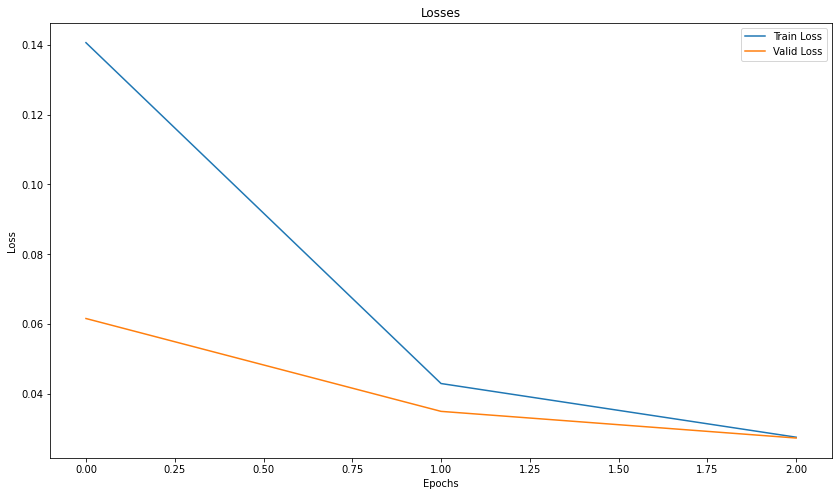

In [ ]:
plt.figure(figsize=(14,8))
plt.title('Losses')
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Valid Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend()
plt.show()

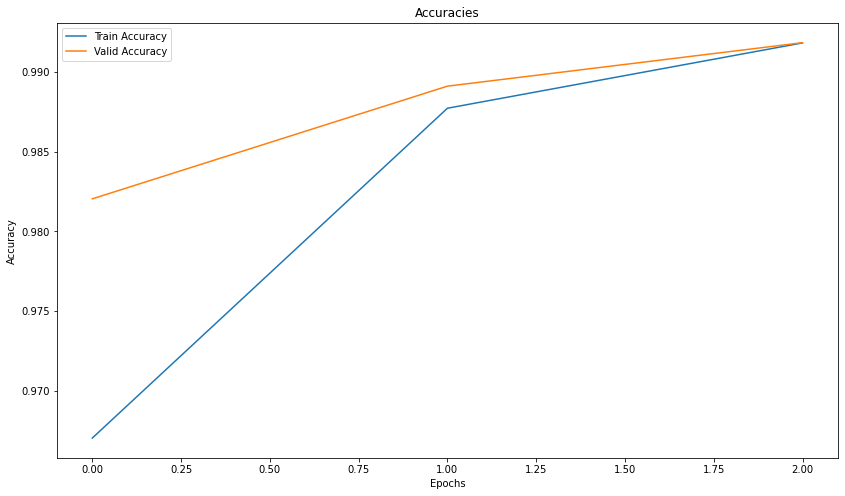

In [ ]:
plt.figure(figsize=(14,8))
plt.title('Accuracies')
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Valid Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend()
plt.show()

In [17]:
! pip install eli5
! pip install sklearn_crfsuite

     |████████████████████████████████| 106 kB 5.3 MB/s 
     |████████████████████████████████| 743 kB 4.9 MB/s 


In [ ]:
X_train, y_train = preprocess(train_samples)
X_test, y_test = preprocess(test_samples)
X_valid, y_valid = preprocess(valid_samples)

In [20]:
y_pred = model.predict(X_test)

In [21]:
y_pred1 = model.predict(X_valid)

In [25]:
y_valid

array([[9, 9, 9, ..., 0, 0, 0],
       [9, 1, 1, ..., 0, 0, 0],
       [9, 2, 6, ..., 0, 0, 0],
       ...,
       [9, 9, 9, ..., 0, 0, 0],
       [9, 9, 3, ..., 0, 0, 0],
       [9, 9, 9, ..., 0, 0, 0]], dtype=int32)

In [32]:
y_pred1[0][0]

array([[-0.99096984, -0.47101733,  0.04562202, ..., -0.97533494,
        -0.8478385 ,  7.3687835 ],
       [-1.709949  , -0.25902256,  0.4292212 , ..., -0.46659046,
        -1.4420549 ,  5.1450505 ],
       [-1.637421  , -0.27566397,  0.50594425, ..., -0.57261187,
        -1.2757113 ,  5.1799397 ],
       ...,
       [ 9.29242   , -0.89243984, -1.0026895 , ..., -1.0308838 ,
        -1.1502146 , -1.8156905 ],
       [ 9.29187   , -0.8931745 , -0.99943465, ..., -1.0278252 ,
        -1.1476634 , -1.8164688 ],
       [ 9.293468  , -0.90048057, -1.0087802 , ..., -1.036474  ,
        -1.1409723 , -1.8161811 ]], dtype=float32)

In [29]:
from sklearn_crfsuite.metrics import flat_classification_report as fcr
classification_analysis = fcr(y_valid, y_pred1[0][0])
print(classification_analysis)

TypeError: ignored